### Scrap for looking at cosine similarity between decoder weights for choice
- look at pairs of features: across both animals, find pairs of features where number of valid sessions > 10
- for each pair of features, what is cosine sim between decoders?

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *
from constants.decoding_constants import *
import seaborn as sns
from scripts.pseudo_decoding.belief_partitions.belief_partition_configs import *
import scripts.pseudo_decoding.belief_partitions.belief_partitions_io as belief_partitions_io

import scipy
import argparse
import copy
import itertools

from tqdm import tqdm

### Step 1, get pairs: (actually, no need, just get all the pairs, look up the weights, compute the cosine sim)

In [2]:
FEATS_PATH = "/data/patrick_res/sessions/{sub}/feats_at_least_3blocks.pickle"
sa_feats = pd.read_pickle(FEATS_PATH.format(sub="SA"))
bl_feats = pd.read_pickle(FEATS_PATH.format(sub="BL"))

In [3]:
all_feats = pd.merge(sa_feats, bl_feats, on="feat", suffixes=("_sa", "_bl"))

In [4]:
def join_sess(row):
    all_sessions = np.concatenate((row.sessions_sa, row.sessions_bl))
    return pd.Series({"sessions": all_sessions, "num_sessions": len(all_sessions)})
all_feats[["sessions", "num_sessions"]] = all_feats.apply(join_sess, axis=1)
all_feats = all_feats[["feat", "sessions", "num_sessions"]]

In [5]:
pairs = []
for i in range(12):
    for j in range(i+1, 12):
        row_i = all_feats.iloc[i]
        row_j = all_feats.iloc[j]
        sessions = set(row_i.sessions) & set(row_j.sessions)
        dim_type = "within_dim" if FEATURE_TO_DIM[row_i.feat] == FEATURE_TO_DIM[row_j.feat] else "across_dim"
        pairs.append({"pair": [row_i.feat, row_j.feat], "dim_type": dim_type, "sessions": sessions, "num_sessions": len(sessions)})
pairs = pd.DataFrame(pairs)


In [10]:
len(pairs[pairs.num_sessions >= 10])


28

<Axes: xlabel='num_sessions', ylabel='Count'>

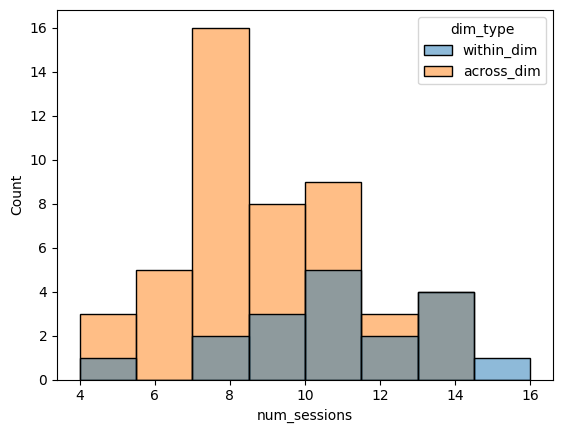

In [6]:
sns.histplot(pairs, x="num_sessions", hue="dim_type")

### Helper

In [4]:
def compute_for_pairs(args):
    res = []
    for (feat_a, feat_b) in tqdm(list(itertools.combinations(FEATURES, 2))):
        try: 
            args_a = copy.deepcopy(args)
            args_a.feat = feat_a
            weights_a = belief_partitions_io.get_weights(args_a)

            args_b = copy.deepcopy(args)
            args_b.feat = feat_b
            weights_b = belief_partitions_io.get_weights(args_b)    
        except Exception as e: 
            if args.shuffle_idx is None:
                raise e
            else: 
                print("Can't find")
                continue

        merged = pd.merge(weights_a, weights_b, on=["Time", "PseudoUnitID"], suffixes=("_a", "_b"))
        if len(merged) == 0:
            continue
        sims = merged.groupby(["Time"]).apply(lambda x: classifier_utils.cosine_sim(x.weightsdiff_a, x.weightsdiff_b)).reset_index(name="cosine_sim")
        # sims = merged.groupby(["Time_choice", "Time_pref"]).apply(lambda x: classifier_utils.cosine_sim(x.weightsdiff_normed_choice, x.weightsdiff_normed_pref)).reset_index(name="cosine_sim")
        sims["dim_type"] = "within_dim" if FEATURE_TO_DIM[feat_a] == FEATURE_TO_DIM[feat_b] else "across_dim"
        res.append(sims)
    return pd.concat(res)

### Load weights, compute cosine sim

In [8]:
args = argparse.Namespace(
    **BeliefPartitionConfigs()._asdict()
)
args.trial_event = "FeedbackOnsetLong"
args.subject = "both"
args.base_output_path = "/data/patrick_res/choice_reward"
args.sig_unit_level = "choice_99th_window_filter_drift"
args.mode = "choice"



In [9]:
res = compute_for_pairs(args)

100%|██████████| 66/66 [00:15<00:00,  4.27it/s]


In [25]:
shuffle_res = []
for i in range(10):
    shuffle_args = copy.deepcopy(args)
    shuffle_args.shuffle_idx = i
    res = compute_for_pairs(shuffle_args)
    res["shuffle_idx"] = i
    shuffle_res.append(res)
shuffle_res = pd.concat(shuffle_res)

  8%|▊         | 5/66 [00:01<00:15,  3.90it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/data/patrick_res/belief_partitions/both_FeedbackOnsetLong_Response_Correct_Choice_Chose_pref_99th_window_filter_drift_units/shuffles/MAGENTA_pref_shuffle_4_models.npy'

<Axes: xlabel='Time', ylabel='cosine_sim'>

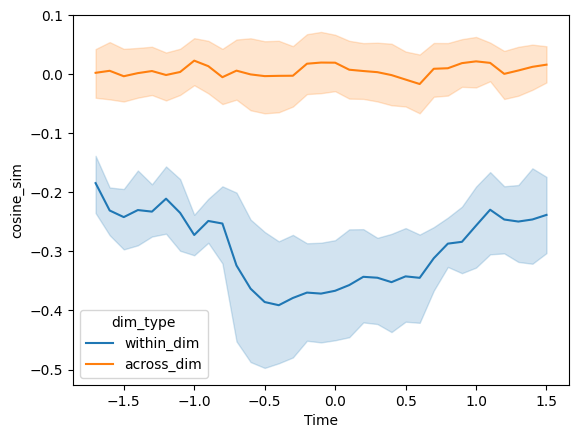

In [10]:
sns.lineplot(res, x="Time", y="cosine_sim", hue="dim_type")

### What about for pref...

In [5]:
args = argparse.Namespace(
    **BeliefPartitionConfigs()._asdict()
)
args.trial_event = "StimOnset"
args.subject = "both"
# args.region_level = "structure_level2_cleaned"
# args.regions = "lateral_prefrontal_cortex_lat_PFC"
args.sig_unit_level = "pref_99th_window_filter_drift"
args.mode = "pref"
args.beh_filters = {"Response": "Correct", "Choice": "Chose"}



In [6]:
true_res = compute_for_pairs(args)

100%|██████████| 66/66 [00:09<00:00,  6.72it/s]


In [7]:
shuffle_res = []
for i in range(10):
    shuffle_args = copy.deepcopy(args)
    shuffle_args.shuffle_idx = i
    res = compute_for_pairs(shuffle_args)
    res["shuffle_idx"] = i
    shuffle_res.append(res)
shuffle_res = pd.concat(shuffle_res)
shuffle_res["dim_type"] = shuffle_res.dim_type + " shuffle"

  0%|          | 0/66 [00:00<?, ?it/s]

  8%|▊         | 5/66 [00:00<00:08,  7.07it/s]

Can't find


 26%|██▌       | 17/66 [00:02<00:06,  7.41it/s]

Can't find


 36%|███▋      | 24/66 [00:03<00:05,  7.34it/s]

Can't find


 52%|█████▏    | 34/66 [00:04<00:04,  7.95it/s]

Can't find


 62%|██████▏   | 41/66 [00:05<00:02,  8.65it/s]

Can't find


 71%|███████   | 47/66 [00:06<00:02,  8.31it/s]

Can't find


 86%|████████▋ | 57/66 [00:07<00:00, 17.27it/s]

Can't find
Can't find
Can't find
Can't find
Can't find


 18%|█▊        | 12/66 [00:00<00:00, 88.64it/s]

Can't find
Can't find
Can't find
Can't find
Can't find
Can't find
Can't find
Can't find
Can't find
Can't find
Can't find


  5%|▍         | 3/66 [00:00<00:07,  8.02it/s]

Can't find


 14%|█▎        | 9/66 [00:01<00:07,  7.77it/s]

Can't find


 20%|█▉        | 13/66 [00:01<00:06,  8.19it/s]

Can't find


 29%|██▉       | 19/66 [00:02<00:05,  8.22it/s]

Can't find


 47%|████▋     | 31/66 [00:03<00:01, 24.99it/s]

Can't find
Can't find
Can't find
Can't find
Can't find
Can't find
Can't find
Can't find
Can't find


 53%|█████▎    | 35/66 [00:03<00:02, 15.32it/s]

Can't find


 64%|██████▎   | 42/66 [00:04<00:02, 10.49it/s]

Can't find


 73%|███████▎  | 48/66 [00:05<00:02,  8.97it/s]

Can't find


 82%|████████▏ | 54/66 [00:06<00:01,  8.44it/s]

Can't find


 88%|████████▊ | 58/66 [00:06<00:00,  8.62it/s]

Can't find


 97%|█████████▋| 64/66 [00:06<00:00, 13.80it/s]

Can't find
Can't find
Can't find


100%|██████████| 66/66 [00:09<00:00,  6.76it/s]


In [8]:
all_res = pd.concat((true_res, shuffle_res[["Time", "cosine_sim", "dim_type"]]))

<Axes: xlabel='Time', ylabel='cosine_sim'>

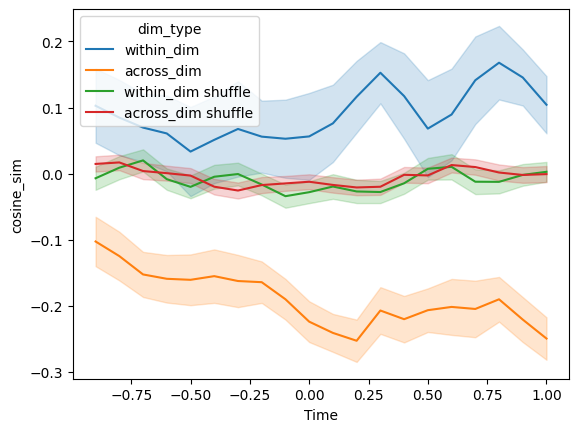

In [9]:
fig, ax = plt.subplots()
sns.lineplot(all_res, x="Time", y="cosine_sim", hue="dim_type", errorbar="se")
